In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dlt
import os
import random
from PIL import Image

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.datasets import cifar10
from keras.utils import np_utils

from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D
from keras.layers.core import Dense,Activation,Dropout,Flatten
from keras.datasets import cifar10
from keras.utils import np_utils


2022-11-28 15:22:18.978258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 15:22:19.053459: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-28 15:22:19.073615: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-28 15:22:19.396758: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
#データセットを読み込んでテンソルに変換

#画像名リスト作成
#ここで指定したディレクトリをまとめてnp配列に変換できる。

#dcgan_filename = os.listdir('./10000all')
dcgan_filename = os.listdir('./20000dcpic')

true_filename = os.listdir('./10000harf')

test_filename = os.listdir('./500test')

#クラスリスト作成
#ex:ファイル名に、"frog"が入ってたら6、"truck"が入っていたら9、のようにラベルを作る。
#ラベルは、[0]のように、要素数１のリストとして出力され、ディレクトリ内のｎ個ファイル分だけラベルを作成し、[[6],[1],…,[5]]のようにｎ×１のリストを作る。
#最後にリストをnp.array型にして返す。

def makeclass(filename):
    list1 = []
    
    for name in filename:
        if "airplane" in name:
            list1.append([0])
        elif "automobile" in name:
            list1.append([1])
        elif "bird" in name:
            list1.append([2])
        elif "cat" in name:
            list1.append([3])
        elif "deer" in name:
            list1.append([4])
        elif "dog" in name:
            list1.append([5])
        elif "frog" in name:
            list1.append([6])
        elif "horse" in name:
            list1.append([7])
        elif "ship" in name:
            list1.append([8])
        elif "truck" in name:
            list1.append([9])
        else:
            list1.append([10])

            
    #list型をnp.arrayに変換
    classlist = np.array(list1)
    return classlist

if ".ipynb_checkpoints" in dcgan_filename:
    dcgan_filename.remove(".ipynb_checkpoints")     #いらないものを消す。

if ".ipynb_checkpoints" in true_filename:
    true_filename.remove(".ipynb_checkpoints")

if ".ipynb_checkpoints" in test_filename:
    test_filename.remove(".ipynb_checkpoints")
#print(filename)

#統計用リスト
scores = []
for n in range(len(dcgan_filename)):
    scores.append(0)


for i in range(10):
    #makeclass関数でラベル作成
    dcgan_label = makeclass(dcgan_filename)
    true_label = makeclass(true_filename)
    test_label = makeclass(test_filename)


    #画像ファイル（str型）に相対パスをつなげる。
    dcgan_filepass = []
    for name in dcgan_filename:
        #dcgan_filepass.append("./10000all/"+name)
        dcgan_filepass.append("./20000dcpic/"+name)


    #print(filepass)

    true_filepass = []
    for name in true_filename:
        true_filepass.append("./10000harf/"+name)


    test_filepass = []
    for name in test_filename:
        test_filepass.append("./500test/"+name)


    #dcgan画像
    #png画像をndarrayに変換 → 一旦listに直して、imlistに追加
    dcgan_imlist = []
    for im in dcgan_filepass:
        pic = np.array(Image.open(im))
        piclist = pic.tolist()
        dcgan_imlist.append(piclist)

    #imlist（list型）をimarray（ndarray型）に変換
    dcgan_imarray = np.array(dcgan_imlist)


    #true画像
    #png画像をndarrayに変換。→一旦listに直して、imlistに追加
    true_imlist = []
    for im in true_filepass:
        pic = np.array(Image.open(im))
        piclist = pic.tolist()
        true_imlist.append(piclist)

    #imlist（list型）をimarray（ndarray型）に変換
    true_imarray = np.array(true_imlist)

    #print(np.concatenate([dcgan_imarray, true_imarray]))

    #test画像
    test_imlist = []

    for im in test_filepass:
        pic = np.array(Image.open(im))
        piclist = pic.tolist()
        test_imlist.append(piclist)

    #imlist（list型）をimarray（ndarray型）に変換
    test_imarray = np.array(test_imlist)

    #使用画像選択!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #Ex_1:CIFAR−１０画像のみ（データ拡張なし）のパターン。
    #


    xttr = true_imarray[0:5000]
    yttr = true_label[0:5000]

    xtcon = np.concatenate([true_imarray[0:5000],dcgan_imarray[0:5000]])
    ytcon = np.concatenate([true_label[0:5000], dcgan_label[0:5000]])

    (x_train, y_train) = (xttr, yttr)
    (x_test, y_test) = (test_imarray, test_label)


    #画像を0-1の範囲で正規化
    x_train=x_train.astype('float32')/255.0
    x_test=x_test.astype('float32')/255.0

    #正解ラベルをOne-Hot表現に変換
    y_train=np_utils.to_categorical(y_train,10)
    y_test=np_utils.to_categorical(y_test,10)

    

    #モデルを構築
    model=Sequential()

    model.add(Conv2D(64,(3,3),padding='same',input_shape=(32,32,3)))
    model.add(Activation('relu'))
    model.add(Conv2D(64,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    #model.add(Dropout(0.25))

    model.add(Conv2D(128,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    #model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10,activation='softmax'))

    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

    history=model.fit(x_train,y_train,batch_size=128,epochs=20,verbose=1,validation_split=0.1)

    #モデルと重みを保存
    json_string=model.to_json()
    open('cifar10_cnn.json',"w").write(json_string)
    model.save_weights('cifar10_cnn.h5')

    #モデルの表示
    #model.summary()

    #評価
    score=model.evaluate(x_test,y_test,verbose=0)
    print('Test loss:',score[0])
    print('Test accuracy:',score[1])


    #使えるor使えないの２択分類器（学習後のモデルを用いて、元のクラス＝predictのクラス→「使える」、もとのクラス≠predictのクラス→「使えない」に振り分ける。）
    #ここでの出力は、ｘ_testの通し番号をリストにまとめたものなので、この通し番号を用いてx_testの何番目の画像かを調べることが可能。ただし、X_testの数値（通し番号）とファイル名の番号は違うことに注意。
    #ex：「generated_truck392.png」の通し番号は1032、等
    #この通し番号は「画像ファイル名」、「スコア」、「x_testの何番目か」という情報を紐付けしている。
    acc_count = []
    usable = []
    unusable = []

    y_test=np_utils.to_categorical(dcgan_label,10)

    y_predict = model.predict(dcgan_imarray, batch_size=32)     #学習済みCNNを用いてクラスを予測。
    predict_classes = np.argmax(y_predict,1)                    #one-hot表現になっているものをラベルと同じ形式（[1]など）に直す。
    true_classes = np.argmax(y_test,1)                          #もともとのラベルも↑と同じ形式に直す。

    for i in range(len(predict_classes)):
        if predict_classes[i] == true_classes[i]:
            acc_count.append(1)
            usable.append(i)
        else:
            acc_count.append(0)
            unusable.append(i)


    acc = np.average(acc_count)
    print(acc)
    #print(usable)
    #print(unusable)
    
    for m in range(len(usable)):
        scores[m] += 1
        
    
    





2022-11-28 15:22:36.796939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 15:22:36.815202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 15:22:36.815297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 15:22:36.815596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Epoch 1/20


2022-11-28 15:22:38.101586: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-11-28 15:22:38.551976: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


36/36 [==============================] - 2s 19ms/step - loss: 2.1172 - accuracy: 0.2100 - val_loss: 1.9601 - val_accuracy: 0.2720
Epoch 2/20
36/36 [==============================] - 0s 11ms/step - loss: 1.7905 - accuracy: 0.3407 - val_loss: 1.6383 - val_accuracy: 0.4300
Epoch 3/20
36/36 [==============================] - 0s 11ms/step - loss: 1.5852 - accuracy: 0.4244 - val_loss: 1.5689 - val_accuracy: 0.4380
Epoch 4/20
36/36 [==============================] - 0s 11ms/step - loss: 1.4745 - accuracy: 0.4616 - val_loss: 1.4563 - val_accuracy: 0.4860
Epoch 5/20
36/36 [==============================] - 0s 11ms/step - loss: 1.3536 - accuracy: 0.5067 - val_loss: 1.3678 - val_accuracy: 0.4720
Epoch 6/20
36/36 [==============================] - 0s 11ms/step - loss: 1.2230 - accuracy: 0.5633 - val_loss: 1.2856 - val_accuracy: 0.5380
Epoch 7/20
36/36 [==============================] - 0s 11ms/step - loss: 1.1176 - accuracy: 0.6007 - val_loss: 1.2294 - val_accuracy: 0.5680
Epoch 8/20
36/36 [======

In [3]:
#ファイルの選別（usable/unusable）
import os
import shutil

target_dirT = './TP'
shutil.rmtree(target_dirT)
os.mkdir(target_dirT)

target_dirF = './FP'
shutil.rmtree(target_dirF)
os.mkdir(target_dirF)

TPlist = []
FPlist = []

for l in range(len(dcgan_filename)):
    if scores[l] > 8:
        TPlist.append(l)
        
    elif scores[l] < 2:
        FPlist.append(l)
        
    else:
        pass
        

for i in range(len(TPlist)):
    file = "./20000dcpic/"+str(dcgan_filename[TPlist[i]])
    target = "TP/{}".format(str(dcgan_filename[TPlist[i]]))
    shutil.copyfile(file, target)


for j in range(len(FPlist)):
    file = "./20000dcpic/"+str(dcgan_filename[FPlist[j]])
    target = "FP/{}".format(str(dcgan_filename[FPlist[j]]))
    shutil.copyfile(file, target)


print("finish")


finish


In [4]:
import pandas as pd

fileTP = os.listdir('./TP')
fileFP = os.listdir('./FP')


def classcount(filename):
    count = [0,0,0,0,0,0,0,0,0,0,0]
    
    for name in filename:
        if "airplane" in name:
            count[0] += 1
        elif "automobile" in name:
            count[1] += 1
        elif "bird" in name:
            count[2] += 1
        elif "cat" in name:
            count[3] += 1
        elif "deer" in name:
            count[4] += 1
        elif "dog" in name:
            count[5] += 1
        elif "frog" in name:
            count[6] += 1
        elif "horse" in name:
            count[7] += 1
        elif "ship" in name:
            count[8] += 1
        elif "truck" in name:
            count[9] += 1
        else:
            count[10] += 1
            print(name)
            
    s1 = pd.Series(count)
    return s1

print("<TP>")
print(classcount(fileTP))
print("\n\n\n\n<FP>")
print(classcount(fileFP))



<TP>
0     1176
1     1188
2     1187
3     1136
4     1185
5     1243
6     1153
7     1196
8     1224
9     1203
10       0
dtype: int64




<FP>
0     694
1     688
2     696
3     742
4     667
5     653
6     719
7     686
8     662
9     675
10      0
dtype: int64


0        10
1        10
2        10
3        10
4        10
         ..
19995     0
19996     0
19997     0
19998     0
19999     0
Length: 20000, dtype: int64


(array([6.5140e+03, 3.6800e+02, 2.8100e+02, 2.4500e+02, 2.8000e+01,
        8.0000e+00, 2.1000e+02, 1.6300e+02, 2.9200e+02, 1.1891e+04]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

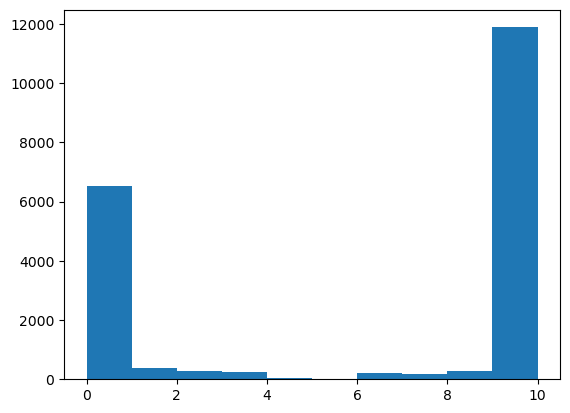

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.Series(scores)
print(df)

plt.hist(df)

In [6]:
def scorecount(filename):
    count = [0,0,0,0,0,0,0,0,0,0,0]
    
    for name in filename:
        if name==0:
            count[0] += 1
        elif name==1:
            count[1] += 1
        elif name==2:
            count[2] += 1
        elif name==3:
            count[3] += 1
        elif name==4:
            count[4] += 1
        elif name==5:
            count[5] += 1
        elif name==6:
            count[6] += 1
        elif name==7:
            count[7] += 1
        elif name==8:
            count[8] += 1
        elif name==9:
            count[9] += 1
        else:
            count[10] += 1
            #print(name)
            
    s1 = pd.Series(count)
    return s1

print(scorecount(scores))

0      6514
1       368
2       281
3       245
4        28
5         8
6       210
7       163
8       292
9       750
10    11141
dtype: int64


In [7]:
TPlist

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
